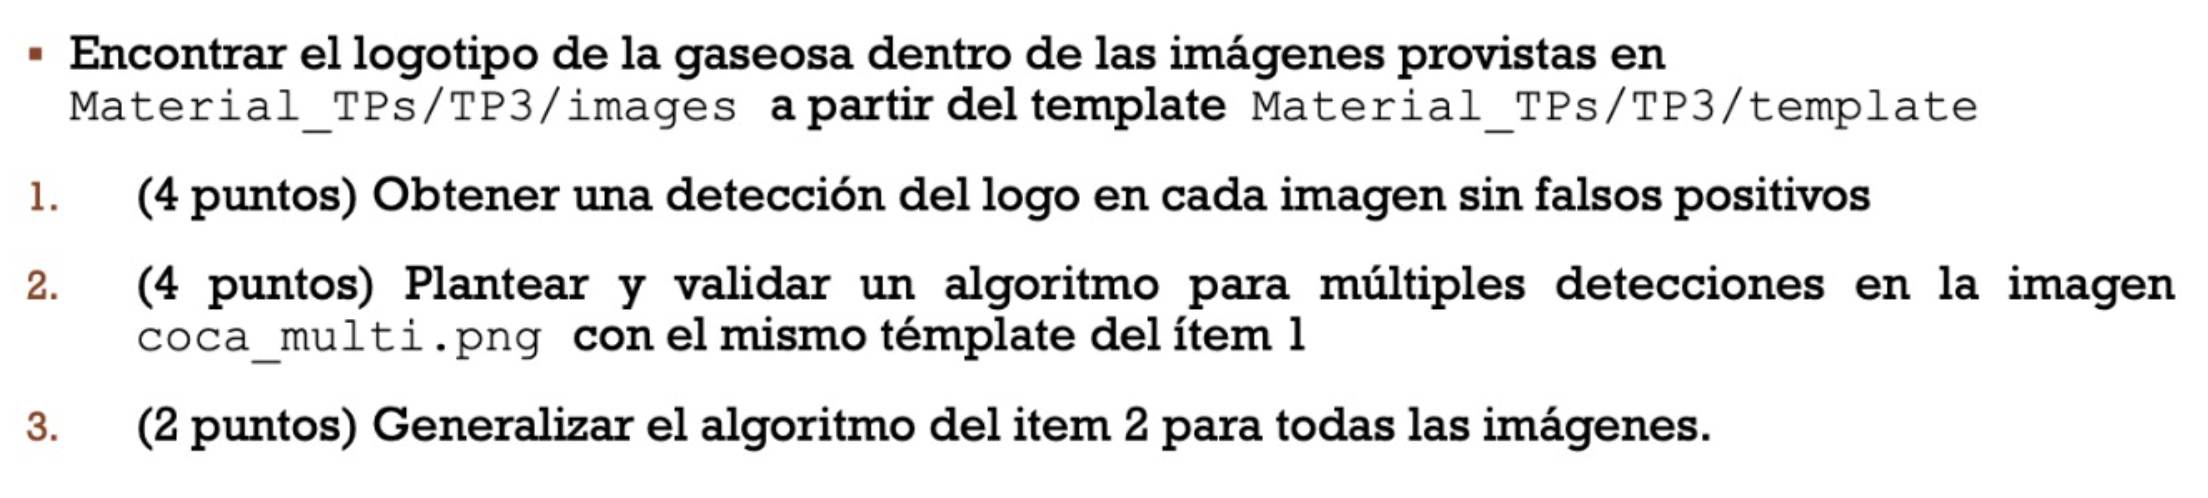

Importamos las imágenes

In [ ]:
# soporte para colab
import sys
import os

# detectar si estamos en colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("entorno colab detectado. configurando proyecto...")

    repo_url = "https://github.com/jbrazonath/VpComp.git"
    repo_name = "VpComp"

    # clonar repo solo si no existe
    if not os.path.exists(repo_name):
        print(f"clonando repo desde: {repo_url}")
        os.system(f"git clone {repo_url}")

    # cambiar al directorio tp3
    tp3_path = "/content/VpComp/Tp3"
    os.chdir(tp3_path)

    print("directorio actual:", os.getcwd())

    # verificaciones básicas
    if not os.path.exists("images"):
        raise RuntimeError("no se encontró la carpeta 'images' en el repo clonado.")

    if not os.path.exists("template"):
        raise RuntimeError("no se encontró la carpeta 'template' en el repo clonado.")

    print("recursos cargados correctamente.")
else:
    print("no se está ejecutando en colab. se asume que los archivos están localmente.")


entorno colab detectado. configurando proyecto...
clonando repo desde: https://github.com/jbrazonath/VpComp.git
directorio actual: /content/VpComp/Tp3
recursos cargados correctamente.


Ejercicio 1

--- INICIANDO SISTEMA ---
Procesando todas las imágenes...

[COCA-COLA-LOGO.jpg] → ORB (Invertido) | Puntos: 674
[coca_logo_1.png] → ORB (Invertido) | Puntos: 609
[coca_logo_2.png] → ORB (Invertido) | Puntos: 593
[coca_multi.png] → Escaneando (Alta Densidad)...
   → ¡Dibujando 9 botellas!

[coca_retro_1.png] → ORB (Normal) | Puntos: 755
[coca_retro_2.png] → ORB (Invertido) | Puntos: 697
[logo_1.png] → ORB (Invertido) | Puntos: 627


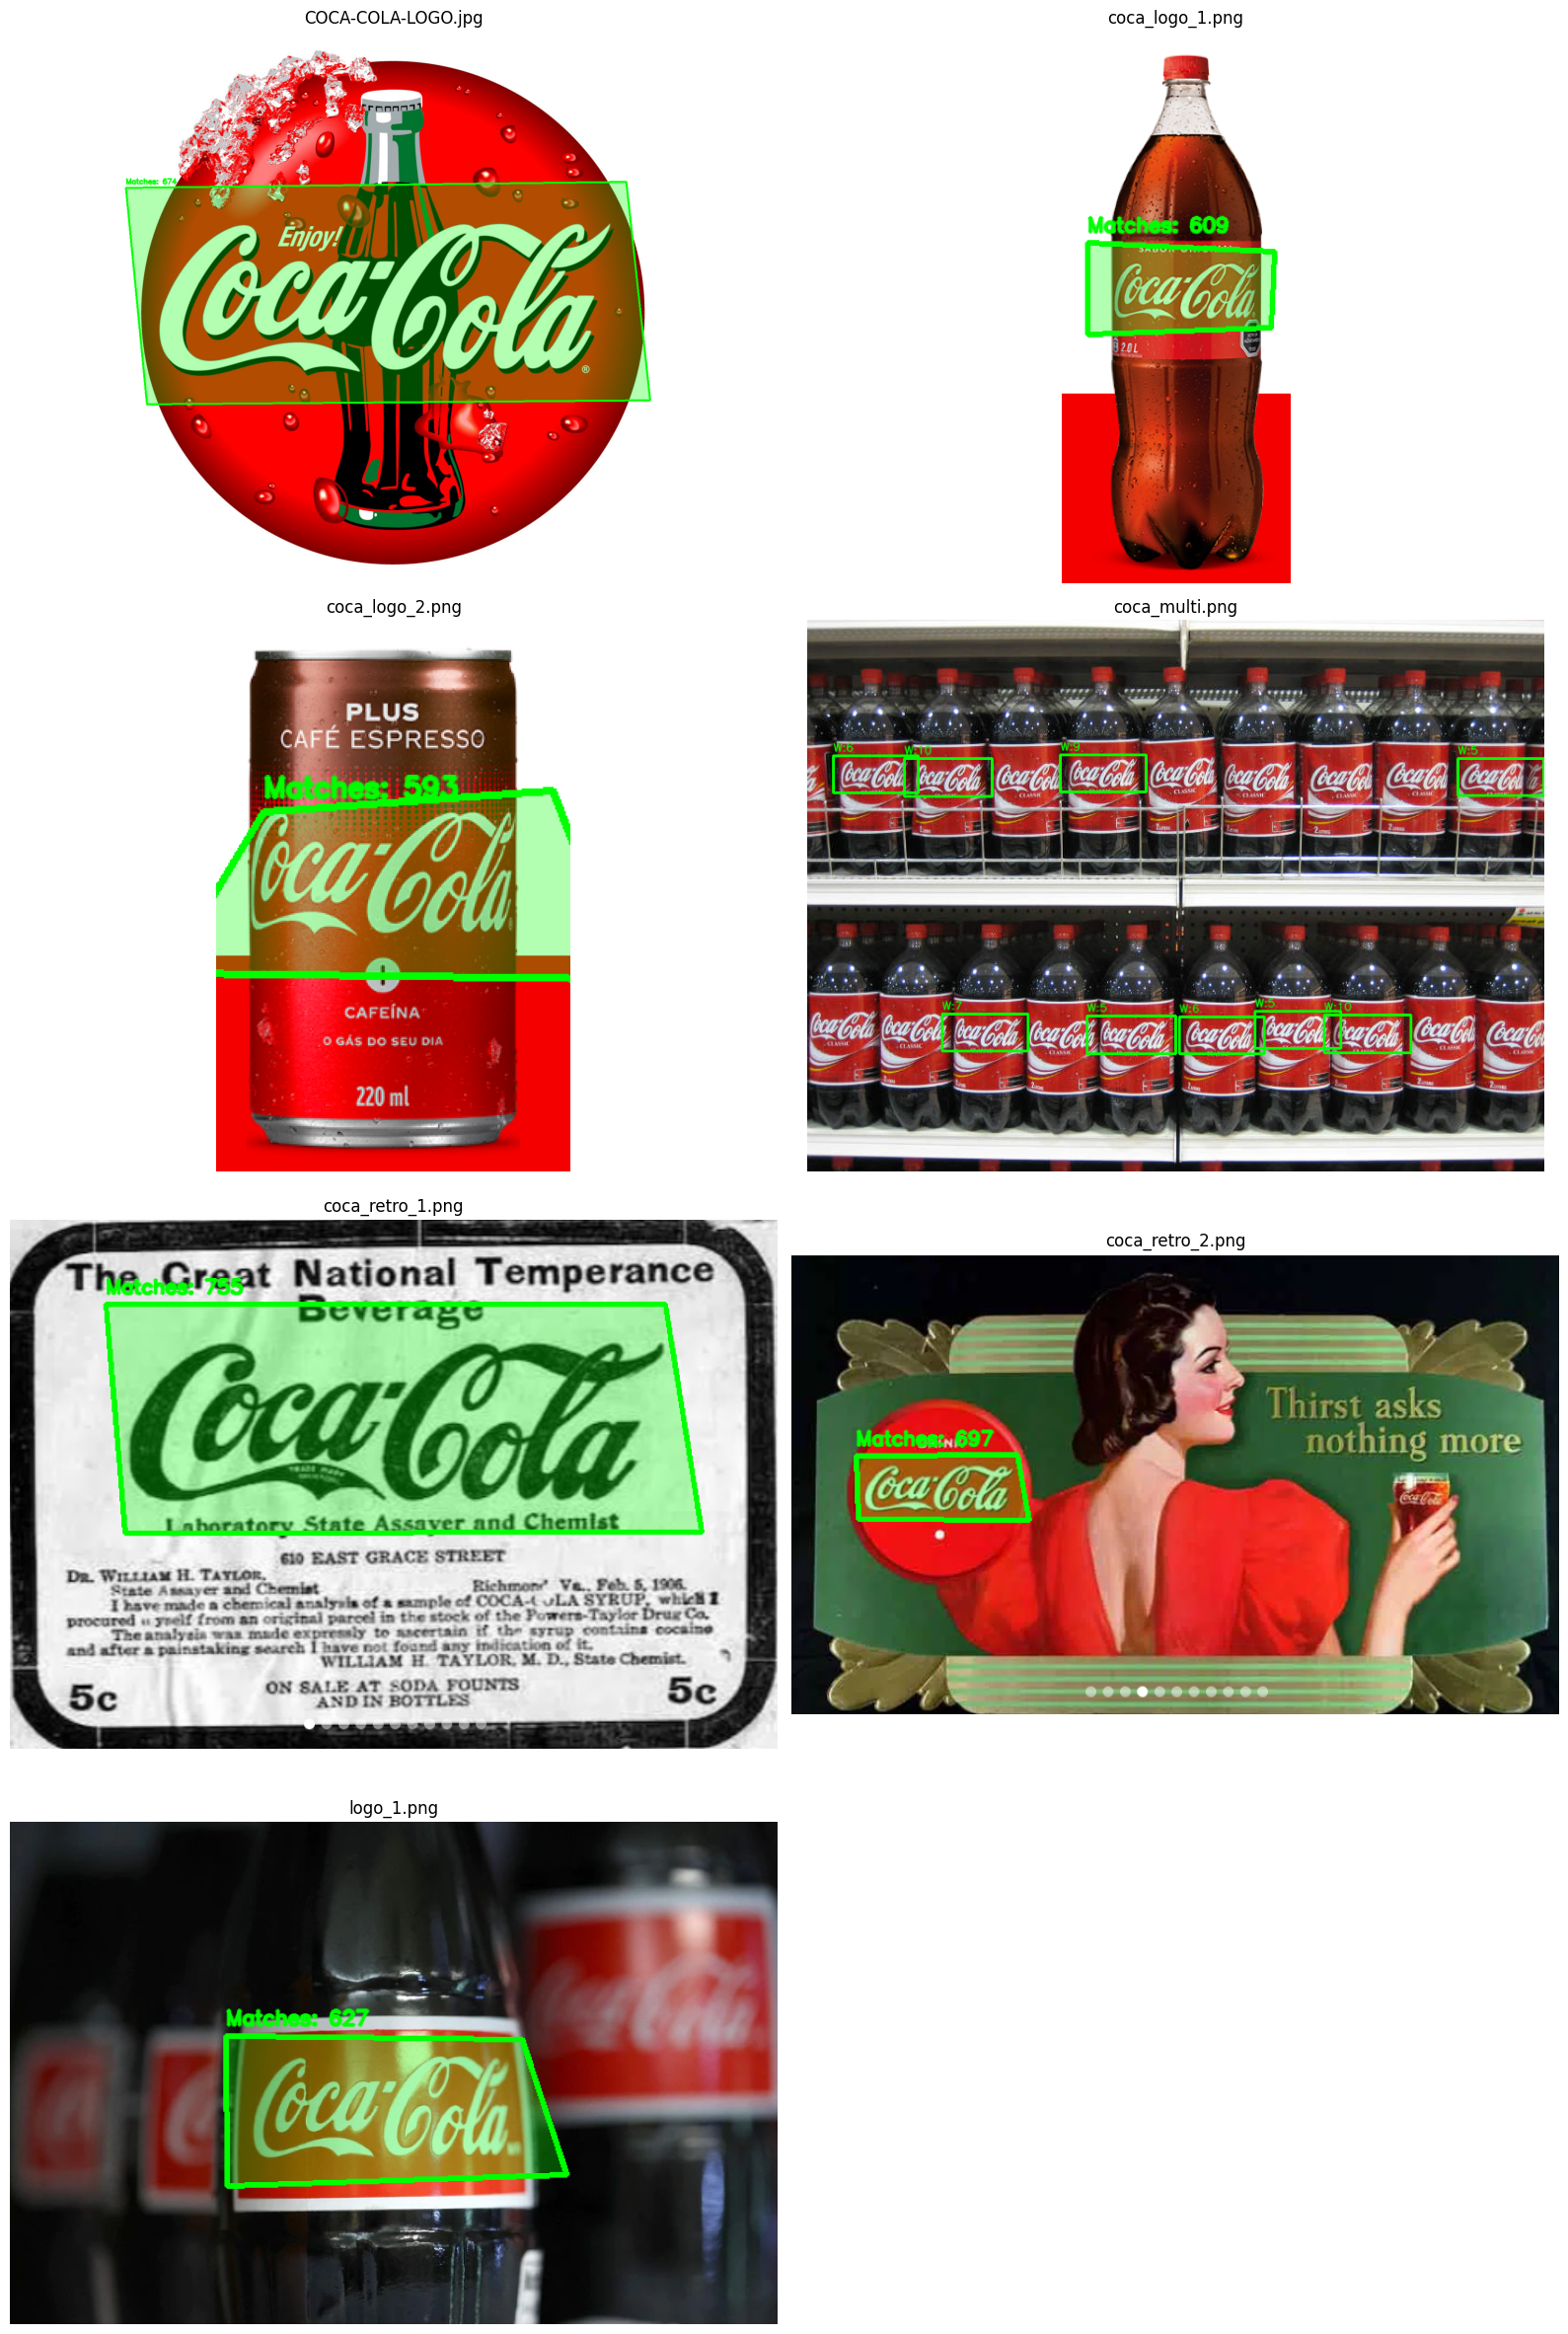


✔ Procesamiento completado.


In [12]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import math

# configuracion de rutas
carpeta_imagenes = '/content/VpComp/Tp3/images'
path_template = '/content/VpComp/Tp3/template/pattern.png'

# cargar template
template_normal = cv2.imread(path_template, 0)
if template_normal is None:
    print("Error: No se pudo cargar el template. Revisa la ruta:", path_template)
    raise SystemExit

template_invertido = cv2.bitwise_not(template_normal)
h_orig, w_orig = template_normal.shape

# configurar orb
orb = cv2.ORB_create(
    nfeatures=15000,
    scaleFactor=1.1,
    nlevels=20,
    edgeThreshold=5,
    patchSize=31
)

kp1_norm, des1_norm = orb.detectAndCompute(template_normal, None)
kp1_inv, des1_inv = orb.detectAndCompute(template_invertido, None)
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

print("--- INICIANDO SISTEMA ---")
print("Procesando todas las imágenes...\n")

# Guardamos resultados para mostrar TODO al final:
resultados = []

# loop principal
for nombre_archivo in sorted(os.listdir(carpeta_imagenes)):

    # Filtrar solo imágenes
    if not nombre_archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    path_img_actual = os.path.join(carpeta_imagenes, nombre_archivo)
    img_rgb = cv2.imread(path_img_actual)

    if img_rgb is None:
        print("Error al leer:", path_img_actual)
        continue

    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    img_final = img_rgb.copy()


    # STRATEGIA A: MULTI (FILTRO DE CONSENSO)

    if "multi" in nombre_archivo.lower():
        print(f"[{nombre_archivo}] → Escaneando (Alta Densidad)...")
        detecciones = []

        for escala in np.linspace(0.12, 0.65, 100):

            w_new = int(w_orig * escala)
            h_new = int(h_orig * escala)
            if w_new < 10:
                continue

            t_inv_escalado = cv2.resize(template_invertido, (w_new, h_new))
            res = cv2.matchTemplate(img_gray, t_inv_escalado, cv2.TM_CCOEFF_NORMED)
            loc = np.where(res >= 0.50)

            for pt in zip(*loc[::-1]):
                detecciones.append([int(pt[0]), int(pt[1]), w_new, h_new])

        if len(detecciones) > 0:

            rects_agrupados, pesos = cv2.groupRectangles(detecciones, groupThreshold=4, eps=0.3)

            # Si no agrupa, probar con menos exigencia
            if len(rects_agrupados) == 0:
                rects_agrupados, pesos = cv2.groupRectangles(detecciones, groupThreshold=2, eps=0.3)

            count = 0

            # --- MODIFICACIÓN AQUÍ: Usamos enumerate para acceder también a los pesos ---
            for i, (x, y, w, h) in enumerate(rects_agrupados):
                ratio = w / float(h)

                # logos anchos, evitar ruido
                if 1.5 < ratio < 4.0:
                    cv2.rectangle(img_final, (x, y), (x + w, y + h), (0, 255, 0), 2)

                    # VISUALIZAR CONFIANZA (PESO)
                    # El peso indica cuántas veces se detectó esa botella en el mismo lugar
                    confianza = pesos[i]
                    if isinstance(confianza, (list, np.ndarray)):
                        confianza = confianza[0] # A veces viene en lista

                    cv2.putText(img_final, f"W:{confianza}", (x, y - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1, cv2.LINE_AA)

                    count += 1

            print(f"   → ¡Dibujando {count} botellas!\n")

        else:
            print("   → No se encontraron coincidencias.\n")


    # STRATEGIA B: ORB (resto de imágenes)
    else:

        kp2, des2 = orb.detectAndCompute(img_gray, None)

        def buscar(des_template, des_img):
            if des_template is None or des_img is None:
                return []
            matches = bf.knnMatch(des_template, des_img, k=2)
            good = []
            for m, n in matches:
                if m.distance < 0.92 * n.distance:
                    good.append(m)
            return good

        good_norm = buscar(des1_norm, des2)
        good_inv = buscar(des1_inv, des2)

        if len(good_norm) >= len(good_inv):
            tipo = "Normal"
            good_matches = good_norm
            kp_template = kp1_norm
        else:
            tipo = "Invertido"
            good_matches = good_inv
            kp_template = kp1_inv

        print(f"[{nombre_archivo}] → ORB ({tipo}) | Puntos: {len(good_matches)}")

        if len(good_matches) >= 5:

            src_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 15.0)

            if M is not None:
                pts_template = np.float32([
                    [0, 0],
                    [0, h_orig - 1],
                    [w_orig - 1, h_orig - 1],
                    [w_orig - 1, 0]
                ]).reshape(-1, 1, 2)

                try:
                    dst = cv2.perspectiveTransform(pts_template, M)
                    dst_int = np.int32(dst)

                    if cv2.contourArea(dst_int) > 300:
                        overlay = img_final.copy()
                        cv2.fillPoly(overlay, [dst_int], (0, 255, 0))
                        cv2.addWeighted(overlay, 0.3, img_final, 0.7, 0, img_final)
                        cv2.polylines(img_final, [dst_int], True, (0, 255, 0), 3)

                        # --- MODIFICACIÓN AQUÍ: VISUALIZAR CONFIANZA (MATCHES) ---
                        coords_texto = tuple(dst_int[0][0])
                        cv2.putText(img_final, f"Matches: {len(good_matches)}",
                                    (coords_texto[0], coords_texto[1] - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

                except:
                    pass

    # Guardar la imagen procesada para mostrar después
    resultados.append((nombre_archivo, img_final.copy()))

# MOSTRAR TODO EN UN GRID PROLIJO
n = len(resultados)
cols = 2
rows = math.ceil(n / cols)

plt.figure(figsize=(16, 6 * rows))

for i, (nombre, img) in enumerate(resultados):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(nombre)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("\n✔ Procesamiento completado.")

Ejercicio 2

--- EJERCICIO 2: DETECCIÓN MÚLTIPLE ---
Procesando 'coca_multi.png' con Template Matching Multi-Escala...
-> Se detectaron 10 botellas válidas.
Mostrando resultado final...


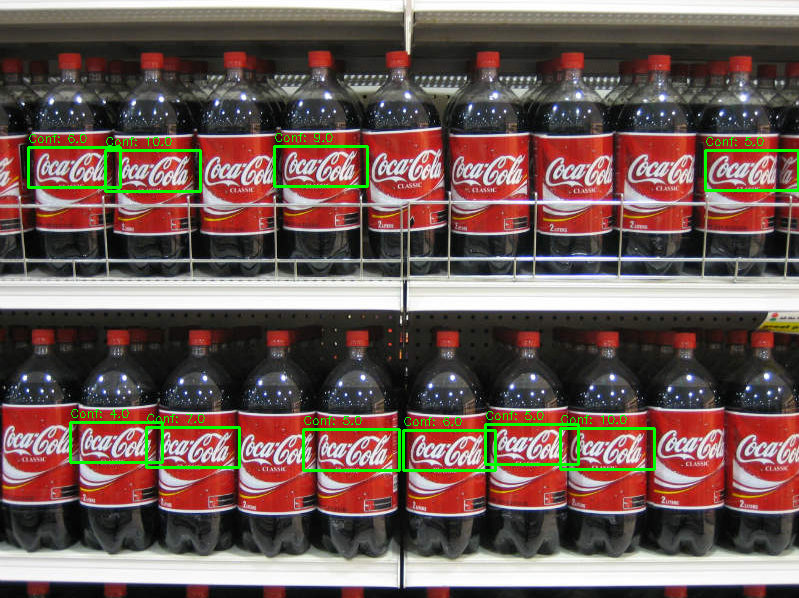

In [13]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

# configuracion
path_img = '/content/VpComp/Tp3/images/coca_multi.png'
path_template = '/content/VpComp/Tp3/template/pattern.png'

# cargar imagenes
if not os.path.exists(path_img) or not os.path.exists(path_template):
    print("¡Error! Revisa las rutas de los archivos.")
    print("Imagen:", path_img)
    print("Template:", path_template)
    raise SystemExit

img_rgb = cv2.imread(path_img)
if img_rgb is None:
    print("Error al leer la imagen:", path_img)
    raise SystemExit

img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

template = cv2.imread(path_template, 0)
if template is None:
    print("Error al leer el template:", path_template)
    raise SystemExit

# Usar el negativo (letras blancas sobre fondo oscuro)
template_invertido = cv2.bitwise_not(template)
h_orig, w_orig = template.shape

print("--- EJERCICIO 2: DETECCIÓN MÚLTIPLE ---")
print("Procesando 'coca_multi.png' con Template Matching Multi-Escala...")

detecciones = []

# escaneo de tamaños
for escala in np.linspace(0.12, 0.65, 100):
    w_new = int(w_orig * escala)
    h_new = int(h_orig * escala)

    if w_new < 10 or h_new < 10:
        continue

    t_inv_escalado = cv2.resize(template_invertido, (w_new, h_new))
    res = cv2.matchTemplate(img_gray, t_inv_escalado, cv2.TM_CCOEFF_NORMED)

    loc = np.where(res >= 0.50)

    for pt in zip(*loc[::-1]):
        detecciones.append([int(pt[0]), int(pt[1]), w_new, h_new])

# filtrado
if len(detecciones) > 0:
    # groupRectangles devuelve DOS cosas: la lista de rectángulos Y la lista de pesos
    rects_agrupados, pesos = cv2.groupRectangles(detecciones, groupThreshold=3, eps=0.3)
else:
    rects_agrupados, pesos = [], []

print(f"-> Se detectaron {len(rects_agrupados)} botellas válidas.")

# dibujar (AHORA CON CONFIANZA)
# Usamos 'enumerate' para tener el índice 'i' y buscar el peso correspondiente
for i, (x, y, w, h) in enumerate(rects_agrupados):
    ratio = w / float(h)
    if 1.5 < ratio < 4.0:
        cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Obtenemos el nivel de confianza (peso)
        confianza = pesos[i]
        # A veces viene dentro de una tupla o array, lo limpiamos:
        if isinstance(confianza, (list, np.ndarray)):
            confianza = confianza[0]

        texto = f"Conf: {confianza:.1f}"

        cv2.putText(img_rgb, texto, (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

print("Mostrando resultado final...")
cv2_imshow(img_rgb)

Ejercicio 3

--- CARGANDO RECURSOS ---

--- INICIANDO EJERCICIO 3: DETECCIÓN GENERALIZADA ---

Procesando: COCA-COLA-LOGO.jpg...
   → Modo ORB (Detección Robusta)
   → Tipo detectado: Invertido | Matches: 674

Procesando: coca_logo_1.png...
   → Modo ORB (Detección Robusta)
   → Tipo detectado: Invertido | Matches: 609

Procesando: coca_logo_2.png...
   → Modo ORB (Detección Robusta)
   → Tipo detectado: Invertido | Matches: 593

Procesando: coca_multi.png...
   → Modo Multi-instancia (Lógica Estricta)
   → Detectadas 10 botellas válidas

Procesando: coca_retro_1.png...
   → Modo ORB (Detección Robusta)
   → Tipo detectado: Normal | Matches: 755

Procesando: coca_retro_2.png...
   → Modo ORB (Detección Robusta)
   → Tipo detectado: Invertido | Matches: 697

Procesando: logo_1.png...
   → Modo ORB (Detección Robusta)
   → Tipo detectado: Invertido | Matches: 627



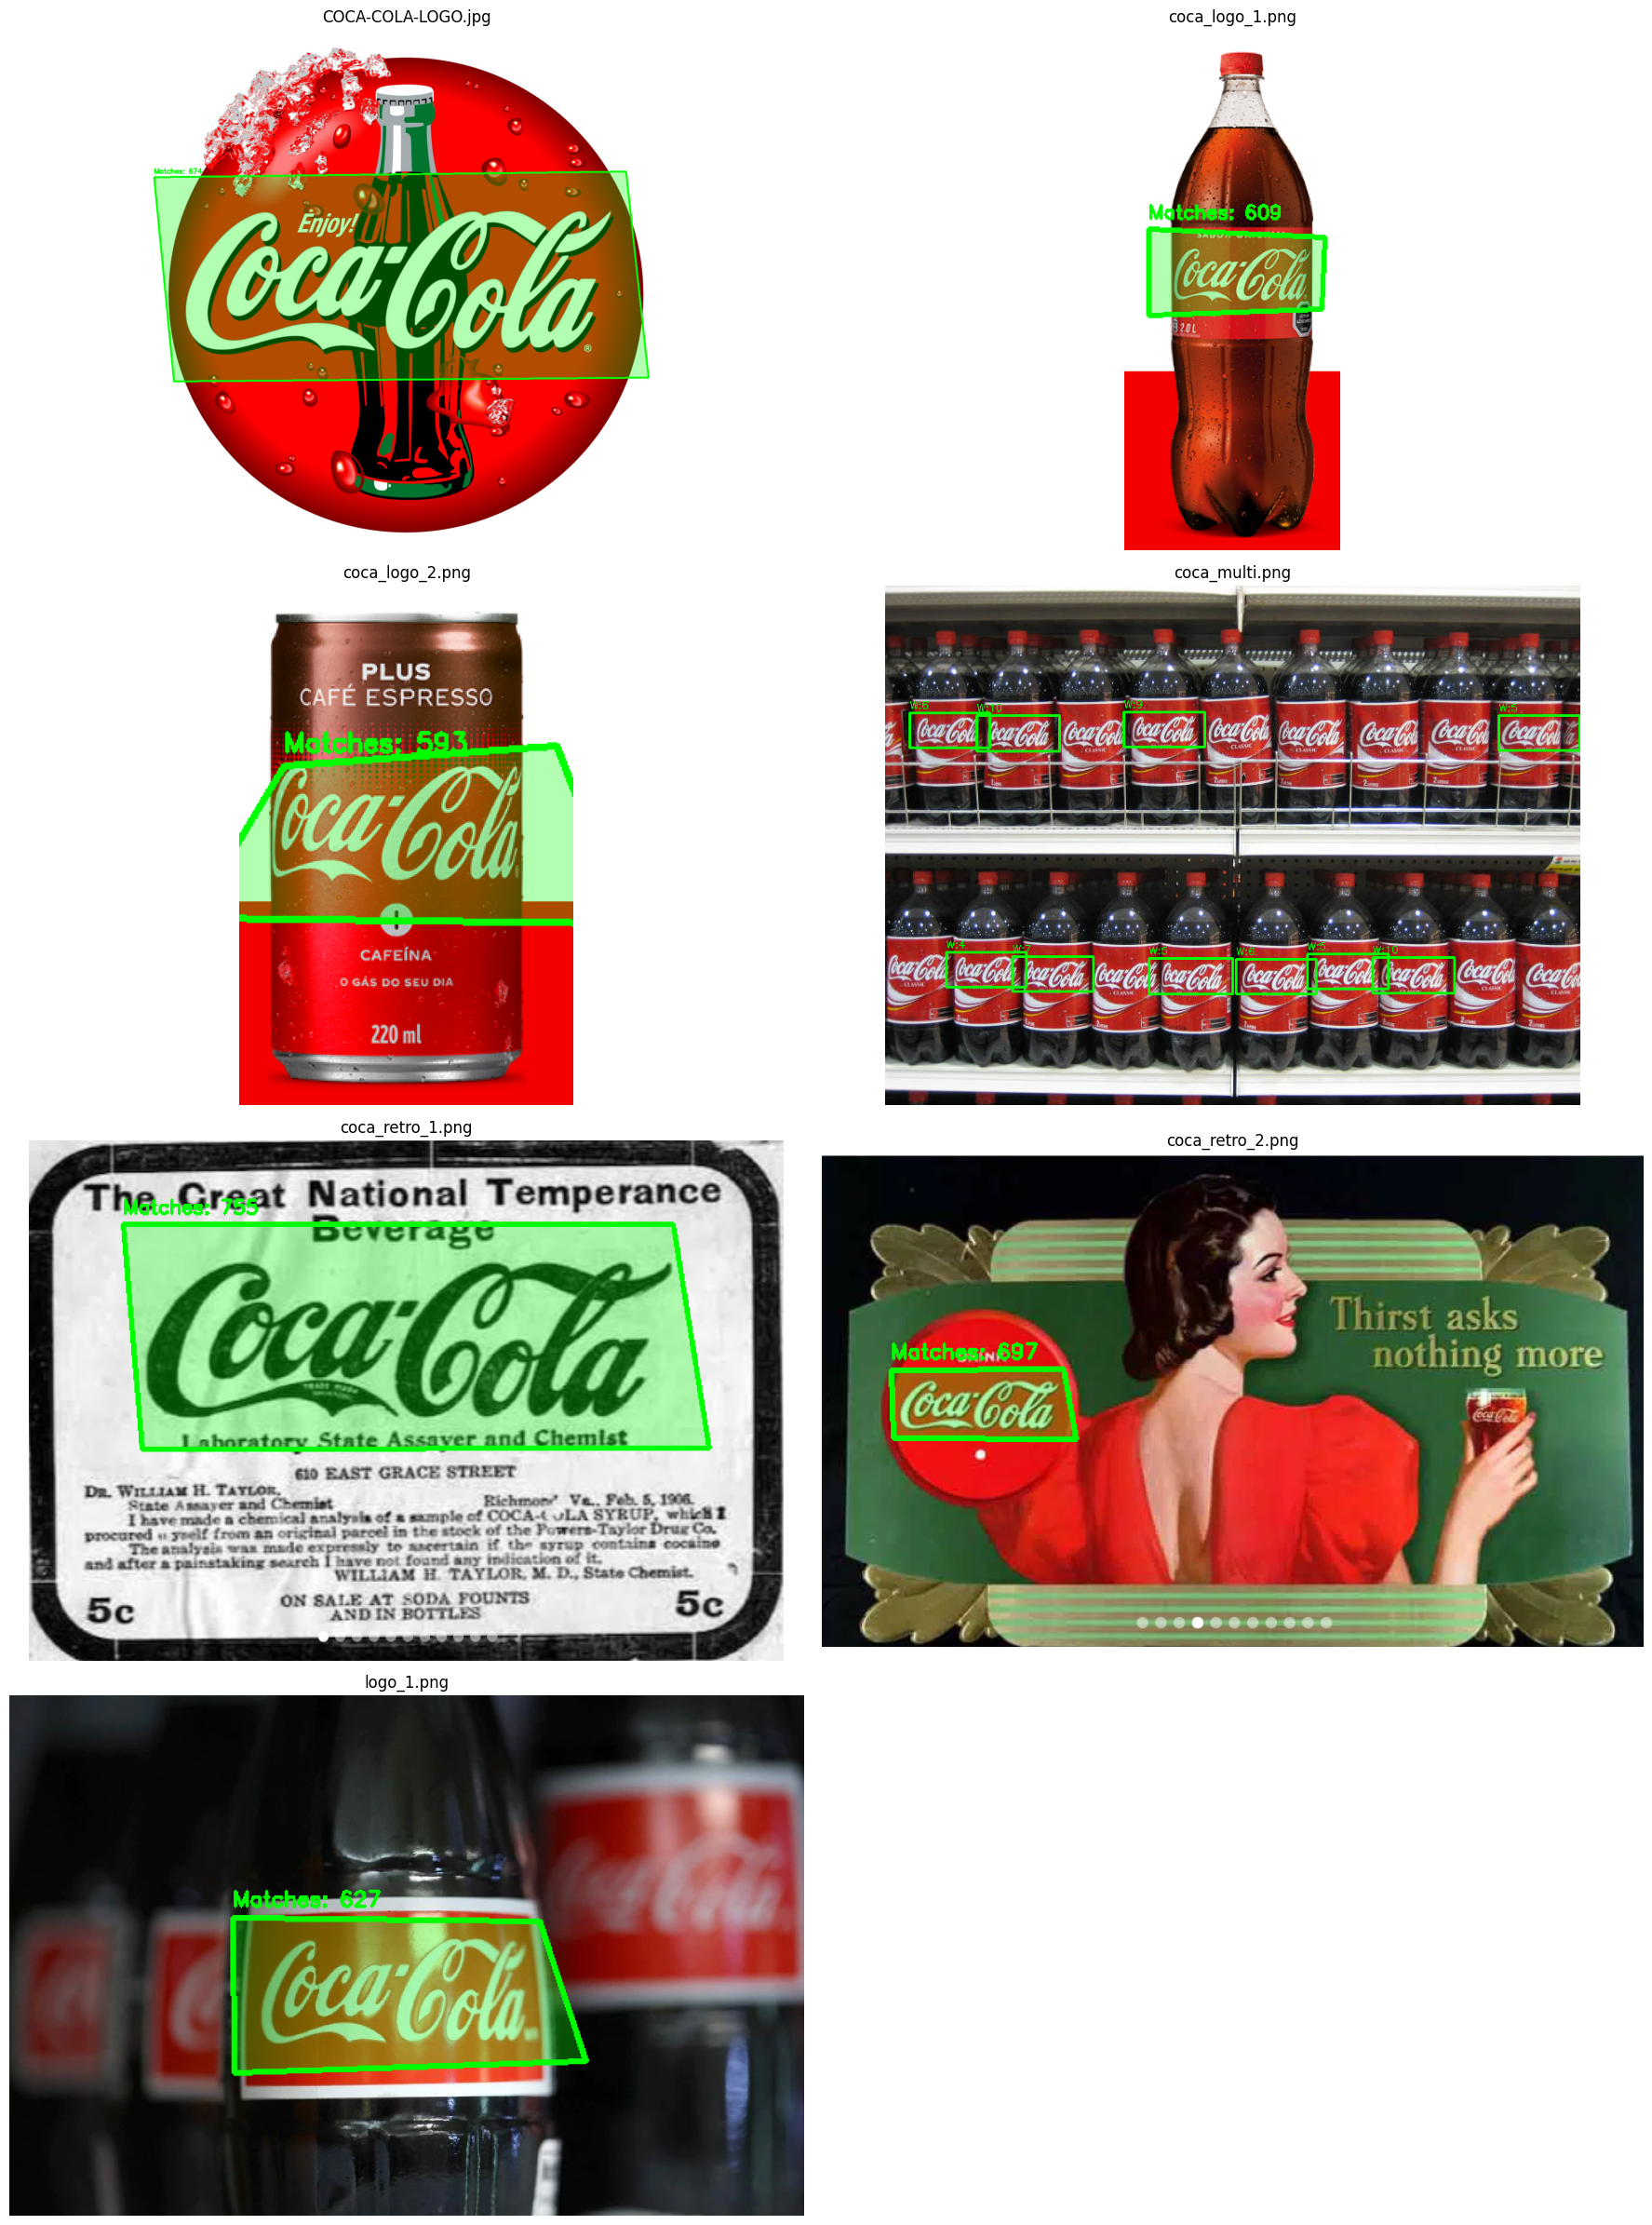


✔ Ejercicio 3 completado.


In [14]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import math

# configuracion
carpeta_imagenes = '/content/VpComp/Tp3/images'
path_template = '/content/VpComp/Tp3/template/pattern.png'

print("--- CARGANDO RECURSOS ---")

template_normal = cv2.imread(path_template, 0)
if template_normal is None:
    print("Error: No se encontró el template pattern.png")
    raise SystemExit

template_invertido = cv2.bitwise_not(template_normal)
h_orig, w_orig = template_normal.shape

# ORB
orb = cv2.ORB_create(
    nfeatures=15000,
    scaleFactor=1.1,
    nlevels=20,
    edgeThreshold=5,
    patchSize=31
)
kp1_norm, des1_norm = orb.detectAndCompute(template_normal, None)
kp1_inv, des1_inv = orb.detectAndCompute(template_invertido, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING)

print("\n--- INICIANDO EJERCICIO 3: DETECCIÓN GENERALIZADA ---\n")

# Guardamos resultados para mostrar todo al final
resultados = []


# loop principal
for nombre_archivo in sorted(os.listdir(carpeta_imagenes)):

    if not nombre_archivo.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    path_img_actual = os.path.join(carpeta_imagenes, nombre_archivo)
    img_rgb = cv2.imread(path_img_actual)

    if img_rgb is None:
        print(f"Error leyendo {path_img_actual}")
        continue

    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    img_final = img_rgb.copy()

    print(f"Procesando: {nombre_archivo}...")

    # estrategia A - multi
    if "multi" in nombre_archivo.lower():
        print("   → Modo Multi-instancia (Lógica Estricta)")

        detecciones = []

        for escala in np.linspace(0.12, 0.65, 100):

            w_new = int(w_orig * escala)
            h_new = int(h_orig * escala)

            if w_new < 10 or h_new < 10:
                continue

            t_inv_escalado = cv2.resize(template_invertido, (w_new, h_new))
            res = cv2.matchTemplate(img_gray, t_inv_escalado, cv2.TM_CCOEFF_NORMED)

            loc = np.where(res >= 0.50)

            for pt in zip(*loc[::-1]):
                detecciones.append([int(pt[0]), int(pt[1]), w_new, h_new])

        if len(detecciones) > 0:
            rects_agrupados, pesos = cv2.groupRectangles(detecciones, groupThreshold=3, eps=0.3)
        else:
            rects_agrupados, pesos = [], []

        count = 0
        # Usamos enumerate para sacar el peso correspondiente a cada rect
        for i, (x, y, w, h) in enumerate(rects_agrupados):
            ratio = w / float(h)
            if 1.5 < ratio < 4.0:
                cv2.rectangle(img_final, (x, y), (x + w, y + h), (0, 255, 0), 2)

                # --- VISUALIZAR CONFIANZA (PESO) ---
                confianza = pesos[i]
                if isinstance(confianza, (list, np.ndarray)):
                    confianza = confianza[0]

                cv2.putText(img_final, f"W:{confianza}", (x, y - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 1)

                count += 1

        print(f"   → Detectadas {count} botellas válidas\n")

    # estrategia B - orb general
    else:
        print("   → Modo ORB (Detección Robusta)")

        kp2, des2 = orb.detectAndCompute(img_gray, None)

        def buscar_coincidencias(des_template, des_img):
            if des_template is None or des_img is None:
                return []
            matches = bf.knnMatch(des_template, des_img, k=2)
            good = []
            try:
                for m, n in matches:
                    if m.distance < 0.92 * n.distance:
                        good.append(m)
            except:
                pass
            return good

        good_norm = buscar_coincidencias(des1_norm, des2)
        good_inv = buscar_coincidencias(des1_inv, des2)

        if len(good_norm) >= len(good_inv):
            good_matches = good_norm
            kp_template = kp1_norm
            tipo = "Normal"
        else:
            good_matches = good_inv
            kp_template = kp1_inv
            tipo = "Invertido"

        print(f"   → Tipo detectado: {tipo} | Matches: {len(good_matches)}")

        if len(good_matches) >= 5:
            src_pts = np.float32([kp_template[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 15.0)

            if M is not None:
                pts_t = np.float32([
                    [0, 0],
                    [0, h_orig - 1],
                    [w_orig - 1, h_orig - 1],
                    [w_orig - 1, 0]
                ]).reshape(-1, 1, 2)

                try:
                    dst = cv2.perspectiveTransform(pts_t, M)
                    dst_pts_int = np.int32(dst)

                    if cv2.contourArea(dst_pts_int) > 300:
                        overlay = img_final.copy()
                        cv2.fillPoly(overlay, [dst_pts_int], (0, 255, 0))
                        cv2.addWeighted(overlay, 0.3, img_final, 0.7, 0, img_final)
                        cv2.polylines(img_final, [dst_pts_int], True, (0, 255, 0), 3)

                        # --- VISUALIZAR CONFIANZA (MATCHES) ---
                        coords_texto = tuple(dst_pts_int[0][0])
                        cv2.putText(img_final, f"Matches: {len(good_matches)}",
                                    (coords_texto[0], coords_texto[1] - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
                except:
                    pass

        print()

    # Guardar para mostrar luego todo junto
    resultados.append((nombre_archivo, img_final.copy()))


# Grid final - Mostrar todo
n = len(resultados)
cols = 2
rows = math.ceil(n / cols)

plt.figure(figsize=(18, 6 * rows))

for i, (nombre, img) in enumerate(resultados):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(nombre)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("\n✔ Ejercicio 3 completado.")